**Краткий отчет**


1) Подобраны итоговые 4-ре датасета и 9 метрик в качестве бенчмарков.

2) Бенчмарки полностью посчитаны для фейсбучного Prophet.

3) Для ARIMA и ExponentialSmoothing  для 2 датасетов. Но нужно еще затюнить, чтобы на следующем этапе корректно определить место разрабатываемого алгоритма.

4) FBProphet  очень круто работает из коробки. Минимум настроек и получается хороший результат. Круто, это еще и быстро. На порядок-два быстрее ARIMA.

5) На следующем этапе - кроссвалидация, красивая визуализация, а также помощь коллегам либо по питоновской обертке либо по бэкэнду на плюсах.


In [2]:
pip install fbprophet

In [3]:
pip install prophet

  Stored in directory: /root/.cache/pip/wheels/77/3e/f3/1c536bf1f871f818686e7fbf31cab18d52787a72dea8640756
Successfully built prophet


In [4]:
pip install ml_metrics

  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [5]:
pip uninstall statsmodels

Uninstalling statsmodels-0.8.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/statsmodels-0.8.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.8.0


In [6]:
#pip install statsmodels
pip install -U statsmodels

    100% |████████████████████████████████| 7.4MB 3.5MB/s 


In [0]:
import statsmodels
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import median_absolute_error
from sklearn.utils import check_array
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime
%matplotlib inline
plt.style.use('Solarize_Light2')

In [0]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
def MdAPE(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def sMAPE(actual, predicted):
    return 100 * np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def sMdAPE(actual, predicted):
    return 100 * np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def RMSPE(actual, predicted):
    return 100 * np.sqrt(np.mean(np.square((actual - predicted)/actual)))

def RMdSPE(actual: np.ndarray, predicted: np.ndarray):
    return 100 * np.sqrt(np.median(np.square((actual - predicted)/actual)))

**I. Загрузка данных**


Milk production

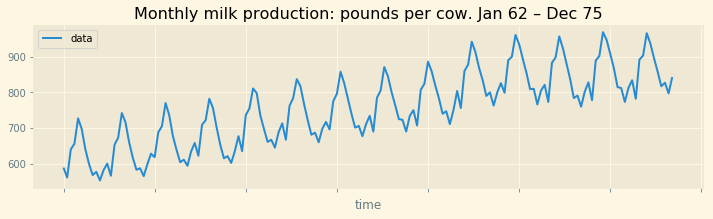

In [17]:
r = requests.get('https://datamarket.com/api/v1/list.json?ds=22ox')
jobj = json.loads(r.text[18:-1])
data = jobj[0]['data']
df = pd.DataFrame(data, columns=['time','data']).set_index('time')
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));
plt.title(jobj[0]['title']);

AEP Hourly Energy Consumption

In [0]:
data_aep = pd.read_csv('AEP_hourly.csv')
aep = pd.DataFrame(data_aep, columns=['Datetime','AEP_MW']).set_index('Datetime')
aep.sort_index(inplace=True)

In [0]:
aep = aep.iloc[115000:]

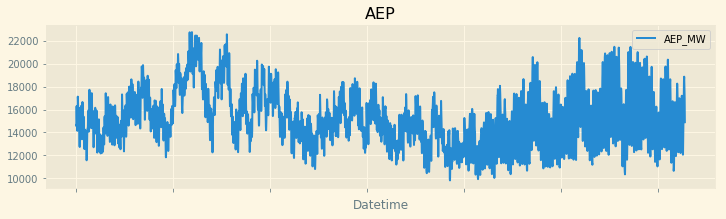

In [274]:
train_aep = aep.iloc[:-100, :]
test_aep = aep.iloc[-100:, :]
train_aep.index = pd.to_datetime(train_aep.index)
test_aep.index = pd.to_datetime(test_aep.index)
pred_aep = test_aep.copy()
aep.plot(figsize=(12,3));
plt.title('AEP');

Dow Jones Index

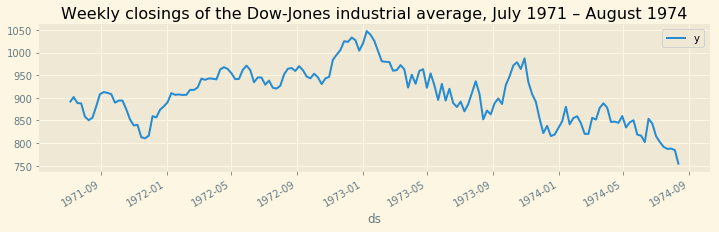

In [21]:
r = requests.get('https://datamarket.com/api/v1/list.json?ds=22yw')
jobj_dj = json.loads(r.text[18:-1])
data_dj = pd.DataFrame(jobj_dj[0]['data'], columns=['ds_','y'])
data_dj['ds'] = data_dj.reset_index().apply(lambda row: datetime.datetime.strptime(str(row['ds_']) + '-1', "%Y-W%W-%w"), axis=1)
data_dj = data_dj.drop(['ds_'], axis=1)
df_dj = data_dj.set_index('ds')
train_dj = df_dj.iloc[:-14, :]
test_dj = df_dj.iloc[-14:, :]
train_dj.index = pd.to_datetime(train_dj.index)
test_dj.index = pd.to_datetime(test_dj.index)
df_dj.plot(figsize=(12,3));
plt.title(jobj_dj[0]['title']);

4) Monthly Australian Imports from Japan

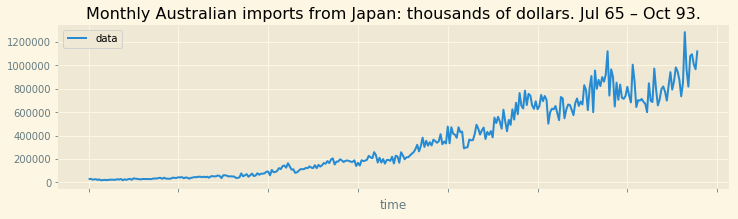

In [95]:
r = requests.get('https://datamarket.com/api/v1/list.json?ds=22qx')
jobj_au = json.loads(r.text[18:-1])
data_au = jobj_au[0]['data']
df_au = pd.DataFrame(data_au, columns=['time','data']).set_index('time')
train_au = df_au.iloc[:-12, :]
test_au = df_au.iloc[-12:, :]
pred_au = test_au.copy()
df_au.plot(figsize=(12,3));
plt.title(jobj_au[0]['title']);

**II. Моделирование  с помощью экспоненциального сглаживания**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


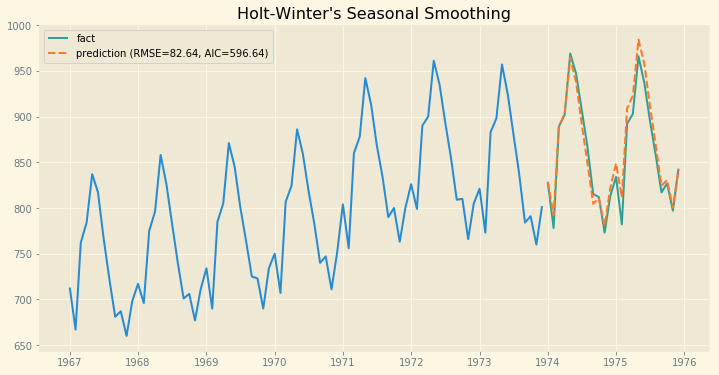

In [183]:
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [185]:
print('MSE, Test:', metrics.mse(test.values, pred.values))
print('RMSE, Test:', metrics.rmse(test.values, pred.values))
print('MAE, Test:', metrics.mae(test.values, pred.values))
print('RMSLE, Test:', metrics.rmsle(test.values, pred.values))
print('MAPE, Test:', MAPE(test.values.flatten(),pred.values.flatten()))
print('MdAPE, Test:', MdAPE(test.values.flatten(),pred.values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),pred.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),pred.values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),pred.values.flatten()))

MSE, Test: 6828.755896366316
RMSE, Test: 82.63628680166066
MAE, Test: 66.68131182826448
RMSLE, Test: 0.09477795667994138
MAPE, Test: 1.2243326442941538
MdAPE, Test: 1.1842249656212493
sMAPE, Test: 1.2170189096707045
sMdAPE, Test: 1.1826741477578355
RMSPE, Test: 1.524286966771256


2) AEP 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


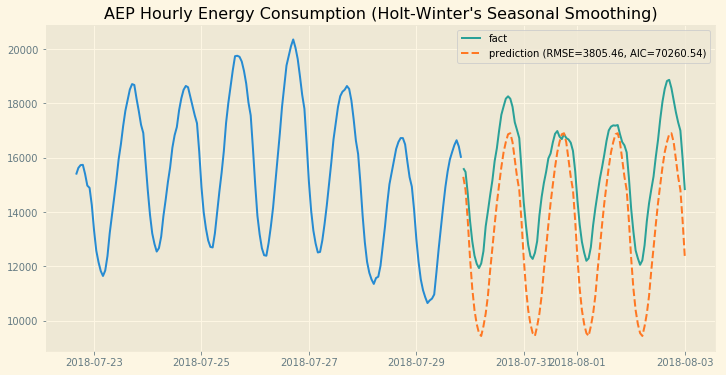

In [286]:
model_aep = ExponentialSmoothing(train_aep,seasonal='add', seasonal_periods=24)
fit = model_aep.fit()
pred_aep = fit.forecast(100)
sse1 = np.sqrt(np.mean(np.square(test_aep.values - pred_aep.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_aep.index[6000:], train_aep.values[6000:]);
ax.plot(test_aep.index, test_aep.values, label='fact');
ax.plot(test_aep.index, pred_aep, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("AEP Hourly Energy Consumption (Holt-Winter's Seasonal Smoothing)");

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


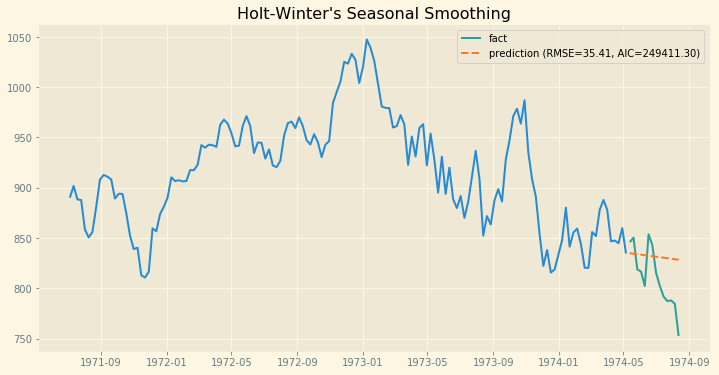

In [370]:
model_dj = ExponentialSmoothing(train_dj['y'], trend='mul', seasonal=None)
fit_dj = model_dj.fit()
pred_dj = fit_dj.forecast(14)

sse1 = np.sqrt(np.mean(np.square(test_dj.values - pred_dj.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_dj.index, train_dj.values);
ax.plot(test_dj.index, test_dj.values, label='fact');
ax.plot(test_dj.index, pred_dj, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


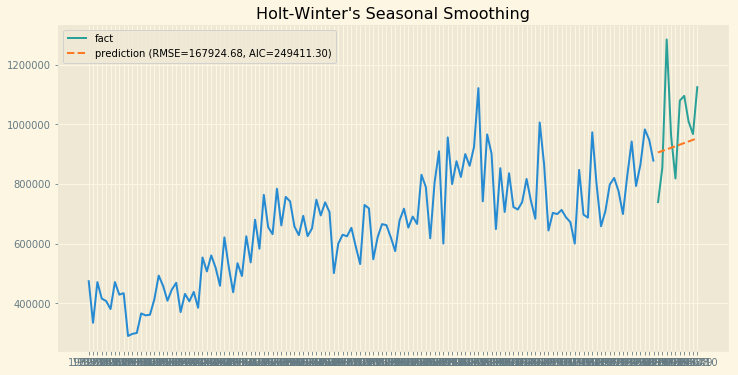

In [421]:
model_au = ExponentialSmoothing(train_au['data'], trend='mul', seasonal=None)
fit_au = model_au.fit()
pred_au = fit_au.forecast(10)

sse1 = np.sqrt(np.mean(np.square(test_au.values - pred_au.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_au.index[200:], train_au.values[200:]);
ax.plot(test_au.index, test_au.values, label='fact');
ax.plot(test_au.index, pred_au, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

** III.  Моделирование с помощью Seasonal ARIMA**

1) Milk Production

In [0]:
def check_ts_is_stationary(df,column_name,pval=0.05):
    if adfuller(df[column_name])[1] < pval:
        print('Time series is stationary',  adfuller(df[column_name])[1])
    else:
        print('Time series is not stationary',  adfuller(df[column_name])[1])       

In [0]:
def diff_time_series(df, column_name, order=1):
    df['diff' + '_' + str(order)] = df[column_name] - df[column_name].shift(order)
    return df.dropna()   

In [28]:
check_ts_is_stationary(df, 'data')

Time series is not stationary


Дифферинцируем

In [0]:
df_diff = diff_time_series(df, 'data')

In [41]:
check_ts_is_stationary(df_diff.dropna(),'diff_1')

Time series is stationary 0.030068004001782334


In [225]:
model = sm.tsa.statespace.SARIMAX(df['data'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                               data   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 12 Apr 2019   AIC                           1074.131
Time:                                    22:47:44   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

In [0]:
pred_arima = results.predict(start=144, end=167, dynamic=True)

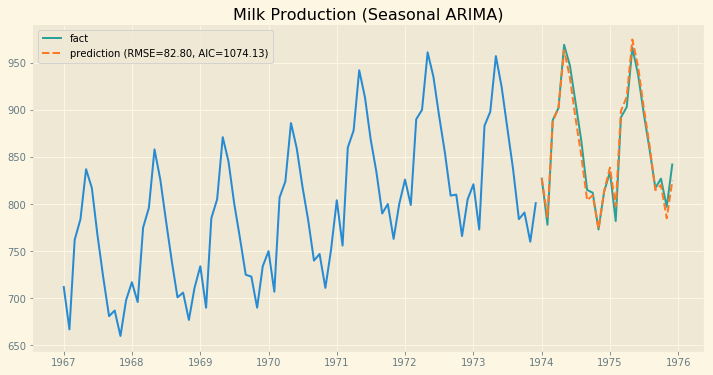

In [227]:
sse1 = np.sqrt(np.mean(np.square(test.values - pred_arima.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, pred_arima, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, results.aic));
ax.legend();
ax.set_title("Milk Production (Seasonal ARIMA)");

In [228]:
print('MSE, Test:', metrics.mse(test.values, pred_arima.values))
print('RMSE, Test:', metrics.rmse(test.values, pred_arima.values))
print('MAE, Test:', metrics.mae(test.values, pred_arima.values))
print('RMSLE, Test:', metrics.rmsle(test.values, pred_arima.values))
print('MAPE, Test:', mean_absolute_percentage_error(test.values.flatten(),pred_arima.values.flatten()))
print('MdAPE, Test:', MdAPE(test.values.flatten(),pred_arima.values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),pred_arima.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),pred_arima.values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),pred_arima.values.flatten()))

MSE, Test: 6855.419655610817
RMSE, Test: 82.79746164956276
MAE, Test: 66.73678781630568
RMSLE, Test: 0.09537469273119155
MAPE, Test: 0.8843424756202047
MdAPE, Test: 0.7968237946175377
sMAPE, Test: 0.886180748042325
sMdAPE, Test: 0.7970761841686342
RMSPE, Test: 1.0915792810553684


2) AEP Hourly Energy Consumption

In [270]:
model_aep = sm.tsa.statespace.SARIMAX(train_aep['AEP_MW'], order=(0,1,2), seasonal_order=(1,1,1,12))
results_aep = model_aep.fit()
print(results_aep.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: ignored

In [0]:
pred_arima_aep = results_aep.predict(start=1152, end=1251)

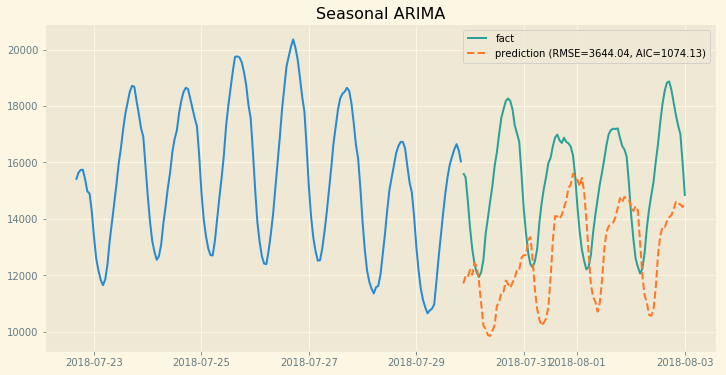

In [267]:
sse1 = np.sqrt(np.mean(np.square(test_aep.values - pred_arima_aep.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_aep.index[21000:], train_aep.values[21000:]);
ax.plot(test_aep.index, test_aep.values, label='fact');
ax.plot(test_aep.index, pred_arima_aep, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, results.aic));
ax.legend();
ax.set_title("AEP Hourly Energy Consumption (Seasonal ARIMA)");

** IV. Моделирование с помощью FBProphet**



**1. Milk Production**

In [0]:
from fbprophet import Prophet

In [0]:
train_fb = train.reset_index()
train_fb.columns = ['ds','y']

In [222]:
m = Prophet()
m.fit(train_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future)

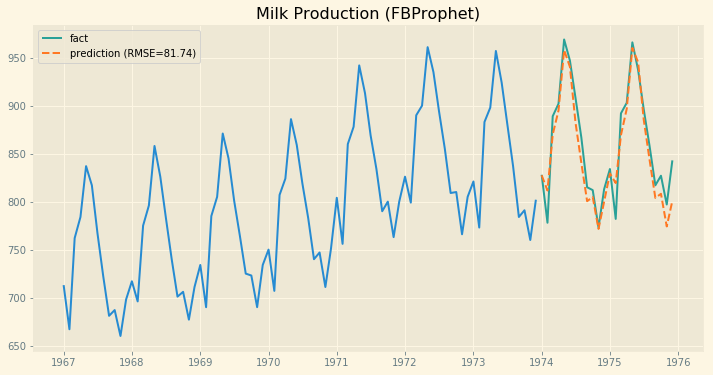

In [224]:
sse1 = np.sqrt(np.mean(np.square(test.values - forecast.yhat.iloc[-24:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, forecast.yhat.iloc[-24:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("Milk Production (FBProphet)");

In [199]:
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-24:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-24:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-24:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-24:].values))
print('MAPE, Test:', mean_absolute_percentage_error(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))

MSE, Test: 6681.302218850347
RMSE, Test: 81.73923304540084
MAE, Test: 65.87173396485302
RMSLE, Test: 0.09431917393109336
MAPE, Test: 1.8383994790616147
MdAPE, Test: 1.6029665110658127
sMAPE, Test: 1.8474966223839397
sMdAPE, Test: 1.6159179352279494
RMSPE, Test: 2.289661913897465


**2) AEP**

In [0]:
train_fb_aep = train_aep.reset_index()
train_fb_aep.columns = ['ds','y']

In [0]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01','2015-01-01','2016-01-01', '2017-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2016-01-18', '2017-01-16'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2016-02-15', '2017-02-20'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2016-05-30', '2017-05-29'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2014-07-04','2015-07-04', '2016-07-04', '2017-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2015-09-07', '2016-09-05', '2017-09-04'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2015-10-12', '2016-10-10', '2017-10-09'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2014-11-11','2015-11-11', '2016-11-11', '2017-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2014-12-25','2015-12-25', '2016-12-25','2017-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

In [218]:
m_aep = Prophet(yearly_seasonality=True, weekly_seasonality=True,holidays=us_public_holidays)
m_aep.fit(train_fb_aep)

In [0]:
future = m_aep.make_future_dataframe(periods=100,freq='H')
forecast = m_aep.predict(future)

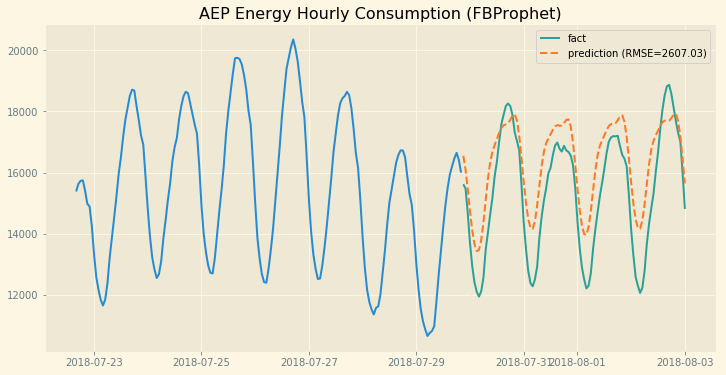

In [220]:
sse1 = np.sqrt(np.mean(np.square(test_aep.values - forecast.yhat.iloc[-100:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_aep.index[21000:], train_aep.values[21000:]);
ax.plot(test_aep.index, test_aep.values, label='fact');
ax.plot(test_aep.index, forecast.yhat.iloc[-100:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("AEP Energy Hourly Consumption (FBProphet)");

In [208]:
print('MSE, Test:', metrics.mse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSE, Test:', metrics.rmse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MAE, Test:', metrics.mae(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MAPE, Test:', mean_absolute_percentage_error(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))

MSE, Test: 6796607.575857603
RMSE, Test: 2607.0304132973984
MAE, Test: 2108.1059489097493
RMSLE, Test: 0.17202876450334267
MAPE, Test: 7.998773767343089
MdAPE, Test: 6.98066584237333
sMAPE, Test: 7.6070036401459555
sMdAPE, Test: 6.7451066119494865
RMSPE, Test: 9.299988480214981


**3) DJIA**

In [0]:
train_fb_dj = train_dj.reset_index()
train_fb_dj.columns = ['ds','y']

In [210]:
m = Prophet(weekly_seasonality=True,yearly_seasonality=True,holidays=us_public_holidays)
m.fit(train_fb_dj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=14,freq='W')
forecast = m.predict(future)

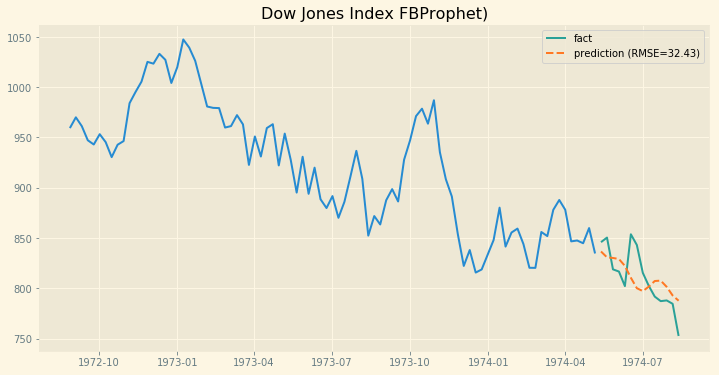

In [215]:
sse1 = np.sqrt(np.mean(np.square(test_dj.values - forecast.yhat.iloc[-14:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_dj.index[60:], train_dj.values[60:]);
ax.plot(test_dj.index, test_dj.values, label='fact');
ax.plot(test_dj.index, forecast.yhat.iloc[-14:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("Dow Jones Index (FBProphet)");

In [214]:
print('MSE, Test:', metrics.mse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSE, Test:', metrics.rmse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAE, Test:', metrics.mae(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAPE, Test:', mean_absolute_percentage_error(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))

MSE, Test: 1051.95179003632
RMSE, Test: 32.43380628351104
MAE, Test: 26.632202882222735
RMSLE, Test: 0.040021164049318485
MAPE, Test: 2.378380814115769
MdAPE, Test: 2.0906650355230427
sMAPE, Test: 2.3850160903602498
sMdAPE, Test: 2.093775037518444
RMSPE, Test: 2.8036082390159494


**4) Australian import**

In [89]:
np.log(100)

4.605170185988092

In [0]:
train_fb_au = train_au.reset_index()
train_fb_au.columns = ['ds','y']
#train_fb_au['y'] = np.log(train_fb_au['y'])

In [159]:
m_au = Prophet(seasonality_mode = 'multiplicative',yearly_seasonality=True,)
m_au.fit(train_fb_au)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m_au.make_future_dataframe(periods=12,freq='M')
forecast = m_au.predict(future)

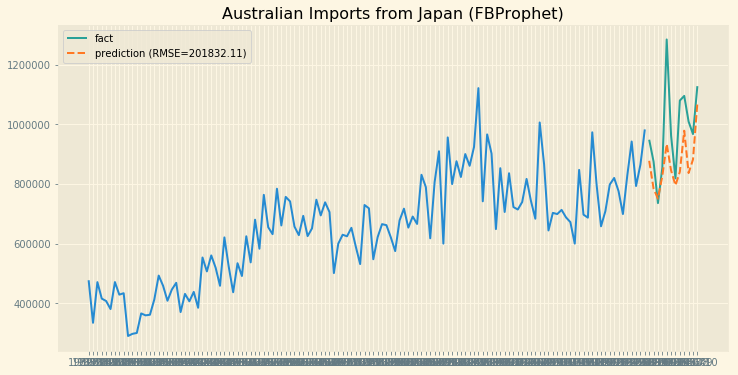

In [161]:
sse1 = np.sqrt(np.mean(np.square(test_au.values - forecast.yhat.iloc[-12:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_au.index[200:], train_au.values[200:]);
ax.plot(test_au.index, test_au.values, label='fact');
ax.plot(test_au.index, forecast.yhat.iloc[-12:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("Australian Imports from Japan (FBProphet)");

In [180]:
print('MSE, Test:', metrics.mse(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSE, Test:', metrics.rmse(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAE, Test:', metrics.mae(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAPE, Test:', mean_absolute_percentage_error(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))

MSE, Test: 40736199149.433784
RMSE, Test: 201832.1063394865
MAE, Test: 161369.42030064794
RMSLE, Test: 0.20952052552975808
MAPE, Test: 10.756239679689152
MdAPE, Test: 9.601250505961257
sMAPE, Test: 11.715887060297465
sMdAPE, Test: 10.088868333959338
RMSPE, Test: 1315.5073922094812
